# `Studio reversibilità catene P e catene Q`

## `Librerie`

In [1]:
import time
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import networkx as nx

from quantecon import gth_solve
from pydtmc import MarkovChain

## `Funzioni`

### Generazione di P reversibile

In [2]:
def genera_P_reversibile(n, seed=42):

    """
    Genera una matrice di transizione P reversibile rispetto a un vettore stazionario π.

    La matrice P è:
    - row-stocastica (le righe sommano a 1)
    - reversibile (soddisfa il detailed balance π_i * P_ij = π_j * P_ji)
    - non banale (costruita da una matrice simmetrica casuale)

    Args:
        n (int)             :           dimensione della matrice quadrata P (numero di stati)
        seed (int)          :           seed per la generazione casuale

    Returns:
        np.ndarray          :           matrice P reversibile e stocastica per riga
    """
    rng = np.random.default_rng(seed)

    # 1. Vettore stazionario con valori casuali in {0,1}
    pi = rng.random(n)
    pi /= pi.sum()

    # 2. Matrice simmetrica S ogni elemento in {0,1}
    S = rng.uniform(np.nextafter(0, 1), 1/n, size=(n, n))
    S = (S + S.T) / 2

    # 3. Costruzione di M e normalizzazione riga
    M = S * pi[None, :]
    P = M / M.sum(axis=1, keepdims=True)

    return P

### Genera Q reversibile

#### Genera una Q reversibile senza accortezze numeriche

In [3]:
def genera_Q_reversibile(n, seed=42):
    """
    Genera una matrice Q reversibile non banale SENZA accortezze numeriche.

    - La divisione F / π può produrre valori molto grandi o piccoli
        Q può avere cattivo condizionamento numerico

    Args:
        n (int)                 :           dimensione della matrice quadrata Q
        seed (int)              :           seed per la generazione casuale

    Returns:
        np.ndarray              :           matrice generatore CTMC reversibile (Q)
    """
    rng = np.random.default_rng(seed)

    # 1. Vettore stazionario con valori casuali in {0,1}
    pi = rng.random(n)
    pi /= pi.sum()

    # 2. Flussi simmetrici senza controllo di scala ogni elemento in {0,1}
    F = rng.uniform(np.nextafter(0, 1), 1/n, size=(n, n))
    F = (F + F.T) / 2
    np.fill_diagonal(F, 0)

    # 3. Costruzione di Q = F / pi_i, righe a somma zero
    Q = F / pi[:, None]
    np.fill_diagonal(Q, 0)
    np.fill_diagonal(Q, -Q.sum(axis=1))

    return Q

#### Q reversibile ma con tassi contenuti

In [4]:
def genera_Q_reversibile_forzata(n, seed=42):
    """
    Genera una matrice Q reversibile non banale, costruita per:

    - garantire stabilità numerica nella divisione Q = F / π
    - mantenere i tassi di uscita q(i) e π dello stesso ordine di grandezza
    - tenere basso il valore di B (massimo tasso d’uscita), così da non degradare l’uniformizzazione in P

    Strategia:
    - π è quasi uniforme, con valori intorno a 1/n
    - F è simmetrica, con valori ∼ 1/(n√n), un ordine più basso di π
      → Q = F / π ha valori moderati e ben bilanciati

    Returns:
        Q (np.ndarray): matrice generatore CTMC reversibile
    """
    np.random.seed(seed)

    # 1. π quasi uniforme ∼ 1/n
    low = 0.75 / n
    high = 1.25 / n
    pi = np.random.uniform(low, high, n)
    pi /= pi.sum()

    # 2. F simmetrica con valori ∼ 1/(n√n)
    F = np.random.uniform(1/(n*np.sqrt(n)), 2.5/(n*np.sqrt(n)), size=(n, n))
    F = (F + F.T) / 2
    np.fill_diagonal(F, 0)

    # 3. Q da detailed balance inverso: Q_ij = F_ij / π_i
    Q = F / pi[:, None]
    np.fill_diagonal(Q, 0)
    np.fill_diagonal(Q, -Q.sum(axis=1))

    return Q

### debug

In [5]:
def spectral_gap(P):
    eigvals = np.linalg.eigvals(P)
    eigvals = np.real_if_close(eigvals)
    eigvals.sort()
    gap = eigvals[-1] - eigvals[-2]
    print(f"[DEBUG] Spectral gap di P: {gap:.6e}")
    print("Autovalori P (ultimi):")
    print(eigvals[-5:])
    return gap

In [6]:
def debug_uniformizzazione(Q):
    """
    Debug completo della matrice P ottenuta da Q tramite uniformizzazione.
    Mostra lambda B, spettro, spectral gap e proprietà stocastiche.
    """
    B = (-np.diag(Q)).max()
    if B <= 0:
        raise ValueError("Uniformizzazione fallita: Q ha diagonale non negativa.")
    
    P = np.eye(Q.shape[0]) + Q / B

    print("\n🔎 [DEBUG UNIFORMIZZAZIONE]")
    print(f"B (massimo tasso di uscita): {B:.6f}")
    print(f"P.min(): {P.min():.6e}, P.max(): {P.max():.6e}")
    
    row_sums = P.sum(axis=1)
    print(f"Somma righe P → min: {row_sums.min():.6f}, max: {row_sums.max():.6f}")

    eigvals = np.linalg.eigvals(P)
    eigvals = np.real_if_close(eigvals)
    eigvals.sort()
    gap = eigvals[-1] - eigvals[-2]
    print(f"Spectral gap di P (uniformizzata): {gap:.6e}")
    
    print("\nAutovalori P (ultimi):")
    print(eigvals[-5:])

In [7]:
Q = genera_Q_reversibile_forzata(1000)
print(Q[1,3], Q[3,1])
debug_uniformizzazione(Q)

0.04600114859876262 0.05371796975600325

🔎 [DEBUG UNIFORMIZZAZIONE]
B (massimo tasso di uscita): 73.495946
P.min(): 0.000000e+00, P.max(): 4.021585e-01
Somma righe P → min: 1.000000, max: 1.000000
Spectral gap di P (uniformizzata): 5.982383e-01

Autovalori P (ultimi):
[0.39913624 0.39953091 0.40095339 0.40176166 1.        ]


In [8]:
P = genera_P_reversibile(1000)
print(P[1,3], P[3,1])
spectral_gap(P)

0.0014049452370872005 0.0009290770095631375
[DEBUG] Spectral gap di P: 9.691256e-01
Autovalori P (ultimi):
[0.02987683 0.03002025 0.03040719 0.03087437 1.        ]


0.9691256272594404

### Ricerca di $\lambda$ tramite funzioni per calcolare gli autovalori

In [9]:
def solve_via_eig_scipy(P_or_Q, discrete=True):
    """
    Calcola π come autovettore sinistro dominante di P o Q tramite ARPACK.
    
    - Per DTMC (P): usa which='LR' (autovalore reale più grande, 1 se ergodica)
    - Per CTMC (Q): usa which='SR' (autovalore reale più piccolo, 0 se ergodica)
    
    Args:
        P_or_Q (np.ndarray): matrice di transizione (P) o generatore (Q)
        discrete (bool): True per DTMC, False per CTMC

    Returns:
        np.ndarray: distribuzione stazionaria π normalizzata
    """
    M = sp.csr_matrix(P_or_Q.T)
    which = 'LR' if discrete else 'SM'

    vals, vecs = spla.eigs(M, k=1, which=which)
    pi = np.real(vecs[:, 0])
    pi /= pi.sum()
    return pi

### Uso del Power-Method

In [10]:
def solve_via_power_numpy(P_or_Q, discrete=True, tol=1e-15, max_iter=500000):

    """
    Calcola il vettore stazionario π usando il Power Method (dense).

    - Se `discrete=True` (DTMC)     :       π_{n+1} = π_n @ P
    - Se `discrete=False` (CTMC)    :       usa uniformizzazione
                                            → P = I + Q / B con B ≥ max q(i)

    Args:
        P_or_Q (np.ndarray)         :       matrice P (stocastica per riga) o Q (generatore)
        discrete (bool)             :       True per P, False per Q
        tol (float)                 :       tolleranza su ||π_{n+1} - π_n||₁
        max_iter (int)              :       numero massimo di iterazioni

    Returns:
        np.ndarray                  :       vettore stazionario π normalizzato
    """

    n = P_or_Q.shape[0]
    pi = np.ones(n) / n

    if discrete:
        P = P_or_Q
    else:
        B = (-np.diag(P_or_Q)).max()
        if B <= 0:
            raise ValueError("Uniformizzazione fallita: Q ha diagonale non negativa.")

        P = np.eye(n) + P_or_Q / B

    for i in range(max_iter):
        pi_new = pi @ P
        pi_new_sum = pi_new.sum()

        if pi_new_sum == 0 or not np.isfinite(pi_new_sum):
            raise RuntimeError("Power Method fallito: somma non valida in π_new.")

        pi_new /= pi_new_sum

        if np.linalg.norm(pi_new - pi, 1) < tol:
            return pi_new

        pi = pi_new

    raise RuntimeError("Power Method non converge entro max_iter.")

In [11]:
def solve_via_power_scipy(P_or_Q, discrete=True, tol=1.1e-15, max_iter=500000):

    """
    Calcola π col Power Method (sparse).

    - Se discrete=True (DTMC)       :       π_{n+1} = π_n @ P
    - Se discrete=False (CTMC)      :       usa uniformizzazione
                                            P = I + Q / B  con B ≥ max q(i)

    Args:
        P_or_Q (array o csr_matrix) :       matrice P (DTMC) o Q (CTMC)
        discrete (bool)             :       True per P, False per Q
        tol (float)                 :       tolleranza ||π_{n+1} - π_n||₁
        max_iter (int)              :       iterazioni massime

    Returns:
        np.ndarray                  :       vettore stazionario π
    """
    
    n = P_or_Q.shape[0]
    if not sp.issparse(P_or_Q):
        P_or_Q = sp.csr_matrix(P_or_Q)

    if not discrete:
        B = (-P_or_Q.diagonal()).max()
        if B <= 0:
            raise ValueError("Uniformizzazione fallita: Q ha diagonale non negativa.")
        
        I = sp.identity(n, format="csr")
        P = I + P_or_Q / B

    else:
        P = P_or_Q

    pi = np.ones(n) / n
    for i in range(max_iter):
        pi_new = pi @ P
        pi_new = np.asarray(pi_new).ravel()

        s = pi_new.sum()
        if s <= 0 or not np.isfinite(s):
            raise RuntimeError("Power Method (sparse) fallito: somma non valida.")
        pi_new /= s

        if np.linalg.norm(pi_new - pi, 1) < tol:
            return pi_new
        pi = pi_new

    raise RuntimeError("Power Method (sparse) non converge entro max_iter.")

### Check reversibilità

In [12]:
def check_reversibility_old(P_or_Q, discrete=True, tol=1e-15):

    """
    Verifica se una matrice P (DTMC) o Q (CTMC) è reversibile,
    usando il metodo più efficiente in base alla dimensione e alla sparsità.
    
    Args:
        P_or_Q (np.ndarray)         :           matrice di transizione P o generatore Q.
        discrete (bool)             :           True se P (DTMC), False se Q (CTMC).
        tol (float)                 :           tolleranza numerica.

    Returns:
        bool                        :           True se reversibile, False altrimenti.
    """
    
    n = P_or_Q.shape[0]
    sparsity = np.count_nonzero(P_or_Q) / (n * n)

    # Scelta del metodo
    if n <= 100:
        pi = gth_solve(P_or_Q)
    else:
        if sparsity < 0.1:
            pi = solve_via_power_scipy(P_or_Q, discrete=discrete)
        else:
            pi = solve_via_power_numpy(P_or_Q, discrete=discrete)

    # Costruzione della matrice dei flussi
    F = np.outer(pi, np.ones_like(pi)) * P_or_Q

    # Test simmetria
    return np.allclose(F, F.T, atol=tol)

In [13]:
def check_reversibility(P_or_Q, discrete=True, tol=1e-15):
    """
    Verifica se una matrice P (DTMC) o Q (CTMC) è reversibile,
    usando il metodo più efficiente in base alla dimensione, alla sparsità
    e al condizionamento numerico.

    Args:
        P_or_Q (np.ndarray)     :           matrice di transizione P o generatore Q.
        discrete (bool)         :           True se P (DTMC), False se Q (CTMC).
        tol (float)             :           tolleranza numerica.

    Returns:
        bool                    :           True se reversibile, False altrimenti.
    """
    n = P_or_Q.shape[0]
    sparsity = np.count_nonzero(P_or_Q) / (n * n)

    if n <= 100:
        pi = gth_solve(P_or_Q)

    else:
        if discrete:
            # Check condizionamento P: righe quasi nulle
            row_mins = P_or_Q.min(axis=1)
            if np.any(row_mins < 1e-12):
                pi = solve_via_eig_scipy(P_or_Q, discrete=True)
            else:
                pi = solve_via_power_scipy(P_or_Q, discrete=True) if sparsity < 0.1 else solve_via_power_numpy(P_or_Q, discrete=True)

        else:
            # Check condizionamento Q: range tassi di uscita
            q_diag = -np.diag(P_or_Q)
            B = q_diag.max()
            min_Q = P_or_Q[P_or_Q > 0].min()
            q_range = B / min_Q
            if q_range > 3*n:
                pi = solve_via_eig_scipy(P_or_Q, discrete=False)
            else:
                pi = solve_via_power_scipy(P_or_Q, discrete=False) if sparsity < 0.1 else solve_via_power_numpy(P_or_Q, discrete=False)

    # Costruzione matrice dei flussi
    F = np.outer(pi, np.ones_like(pi)) * P_or_Q
    return np.allclose(F, F.T, atol=tol)

### Funzione Test per P tra nostro metodo e `pydtcm`

In [14]:
def test_confronto_reversibilita(n_matrici=100, n=100, seed=123):
    match = 0
    mismatch = 0

    for i in range(n_matrici):
        # Genera una matrice reversibile non banale
        P = genera_P_reversibile(n, seed=seed + i)

        try:
            # Nostro check
            nostro = check_reversibility(P)

            # PyDTMC check
            mc = MarkovChain(P)
            pydtmc = mc.is_reversible

            if nostro == pydtmc:
                match += 1
            else:
                mismatch += 1
                print(f"Mismatch alla matrice {i}: nostro={nostro}, pydtmc={pydtmc}")

        except Exception as e:
            mismatch += 1
            print(f"Errore alla matrice {i}: {e}")

    print(f"\nRisultati su {n_matrici} matrici:")
    print(f"Match: {match}")
    print(f"Mismatch o errori: {mismatch}")

### Funzioni test tempi

In [15]:
def risoluzione():
    """Calcola la risoluzione del timer con time.monotonic."""
    start = time.monotonic()
    while time.monotonic() == start:
        pass
    return time.monotonic() - start

In [16]:
def tempo_per_funzione(funzione, resolution):
    tmin = resolution
    count = 0
    start = time.monotonic()
    while time.monotonic() - start < tmin:
        bol = funzione()
        if not bol:
            print("⚠️ Funzione non ha restituito True.")
        count += 1
    return (time.monotonic() - start) / count

In [17]:
def calcola_tempi(funzione_check, C=100, n_punti=20, n_matrici=10, seed=123, discrete=True, forzata=False):
    """
    Misura il tempo medio del controllo di reversibilità su n_matrici diverse per ogni dimensione.

    Args:
        funzione_check (str)                    :           'nostro', 'nostro2' o 'pydtmc'
        C (int)                                 :           valore massimo della dimensione n.
        n_punti (int)                           :           numero di punti da campionare.
        n_matrici (int)                         :           quante matrici generare per ogni n.
        seed (int)                              :           seed di partenza.
        discrete (bool)                         :           True per P (DTMC), False per Q (CTMC).
        forzata (bool)                          :           se True, genera Q forzate (solo se discrete=False)

    Returns:
        list of (n, tempo_medio)
    """

    A = 10
    B = C ** (1 / (n_punti - 1))
    risultati = []
    resolution = risoluzione() * 10000

    for i in range(n_punti):
        n = int(A * (B ** i))
        tempi = []

        for j in range(n_matrici):
            # 1. Genera la matrice
            if discrete:
                P_or_Q = genera_P_reversibile(n, seed + j)
            else:
                if forzata:
                    P_or_Q = genera_Q_reversibile_forzata(n, seed + j)
                else:
                    P_or_Q = genera_Q_reversibile(n, seed + j)

            # 2. Seleziona la funzione da misurare
            if funzione_check == "nostro":
                funzione = lambda: check_reversibility(P_or_Q, discrete=discrete)
            elif funzione_check == "nostro2":
                funzione = lambda: check_reversibility_old(P_or_Q, discrete=discrete)
            elif funzione_check == "pydtmc":
                funzione = lambda: MarkovChain(P_or_Q).is_reversible
            else:
                raise ValueError(f"Metodo '{funzione_check}' non riconosciuto.")

            # 3. Misura il tempo medio per questa matrice
            t = tempo_per_funzione(funzione, resolution)
            tempi.append(t)
        
        t_median = np.median(tempi)

        # 4. Tempo medio (mediana) su tutte le matrici generate per n
        risultati.append((n, t_median))

    return risultati

## `Test Reversibilità`

### Confronto tra mio metodo e `pydctm`
Confrontiamo la correttezza di reversibilità tra il nostro metodo e quello interno alla libreria `pydctm`

In [19]:
test_confronto_reversibilita(n_matrici=100, n=100)


Risultati su 100 matrici:
Match: 100
Mismatch o errori: 0


#### Ora confrontiamo i tempi per il controllo della reversibilità e confrontiamo il nostro metodo e quello di `pydctm`

In [27]:
# Testa nostro metodo su P reversibili
ris_nostro = calcola_tempi("nostro", C=1000, n_punti=50, n_matrici=1)

# Testa PyDTMC su P reversibili
ris_pydtmc = calcola_tempi("pydtmc", C=100, n_punti=50, n_matrici=1)

[[1.89849662e-02 6.95524372e-04 1.04064168e-02 1.42626072e-03
  4.14627333e-03 2.48738964e-02 3.53834535e-02 1.78360909e-03
  3.58197402e-02 2.60015742e-02]
 [6.95524372e-04 3.81998257e-05 6.42221783e-04 4.59834912e-04
  1.66275218e-04 1.34401694e-03 1.95582850e-03 8.78374741e-04
  3.01154309e-03 2.00697084e-03]
 [1.04064168e-02 6.42221783e-04 8.41989679e-04 1.78270767e-03
  1.13068097e-03 6.00245307e-03 9.74951272e-03 2.28367192e-03
  6.85432181e-03 1.07991887e-02]
 [1.42626072e-03 4.59834912e-04 1.78270767e-03 2.06695276e-03
  7.14995537e-04 4.46415030e-03 4.01404069e-03 1.05900186e-03
  4.35742382e-03 4.10254049e-03]
 [4.14627333e-03 1.66275218e-04 1.13068097e-03 7.14995537e-04
  1.41640781e-03 4.67516162e-03 5.84495335e-03 1.78054561e-03
  2.31396355e-03 7.28760825e-03]
 [2.48738964e-02 1.34401694e-03 6.00245307e-03 4.46415030e-03
  4.67516162e-03 1.16561900e-03 2.85421364e-02 1.30720356e-02
  3.62606245e-02 3.09001801e-02]
 [3.53834535e-02 1.95582850e-03 9.74951272e-03 4.01404069e

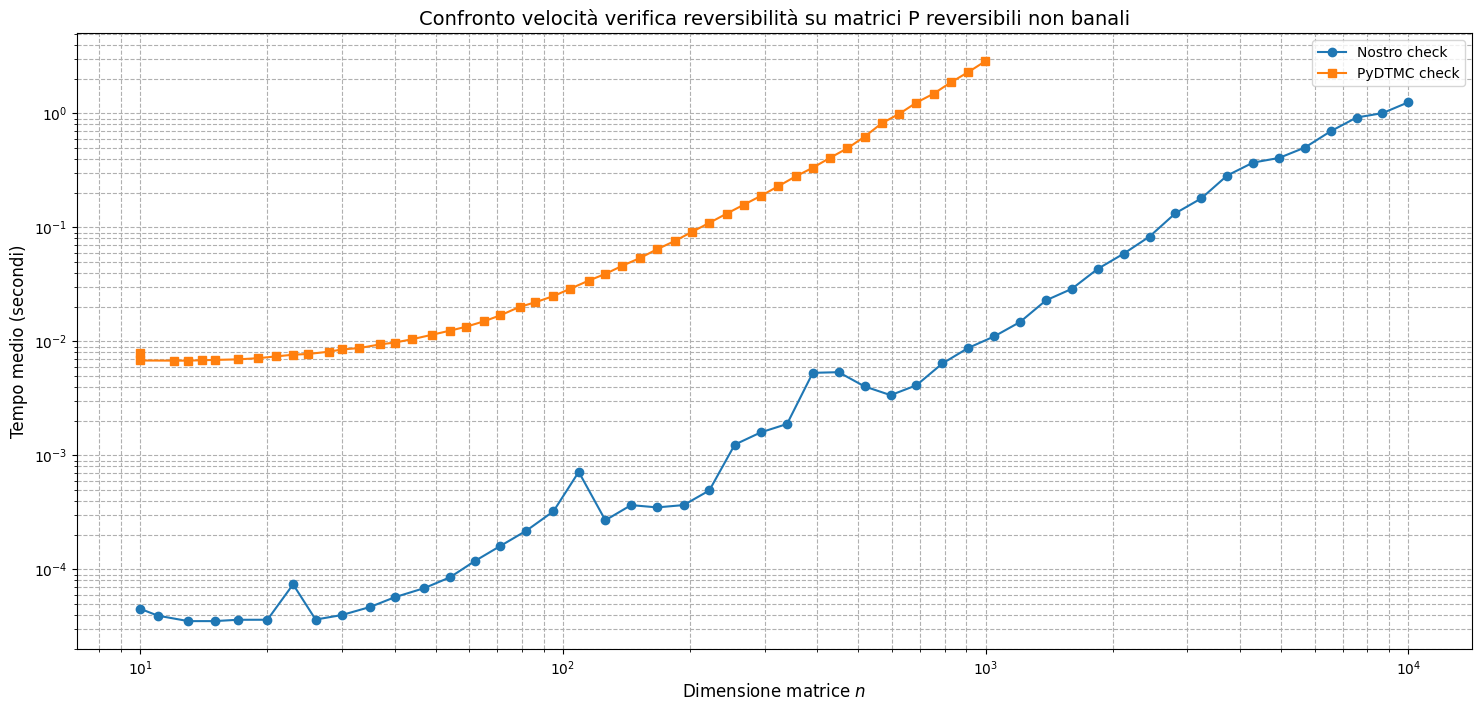

In [21]:
# Grafico
plt.figure(figsize=(18,8))
plt.plot([r[0] for r in ris_nostro], [r[1] for r in ris_nostro], 'o-', label="Nostro check")
plt.plot([r[0] for r in ris_pydtmc], [r[1] for r in ris_pydtmc], 's-', label="PyDTMC check")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dimensione matrice $n$', fontsize=12)
plt.ylabel('Tempo medio (secondi)', fontsize=12)
plt.title('Confronto velocità verifica reversibilità su matrici P reversibili non banali', fontsize=14)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig("P_nostro_vs_pydctm.svg", dpi=300, format="svg", bbox_inches = "tight")
plt.show()

### Confronto tra matrici P e matrici Q ben condizionate per la uniformizzazione

In [22]:
# Testa su P reversibili
ris_nostro = calcola_tempi("nostro", C=100, n_punti=50, n_matrici=1)

# Testa su Q reversibili "facili"
ris_pydtmc = calcola_tempi("nostro", C=100, n_punti=50, n_matrici=1, discrete=False, forzata=True)

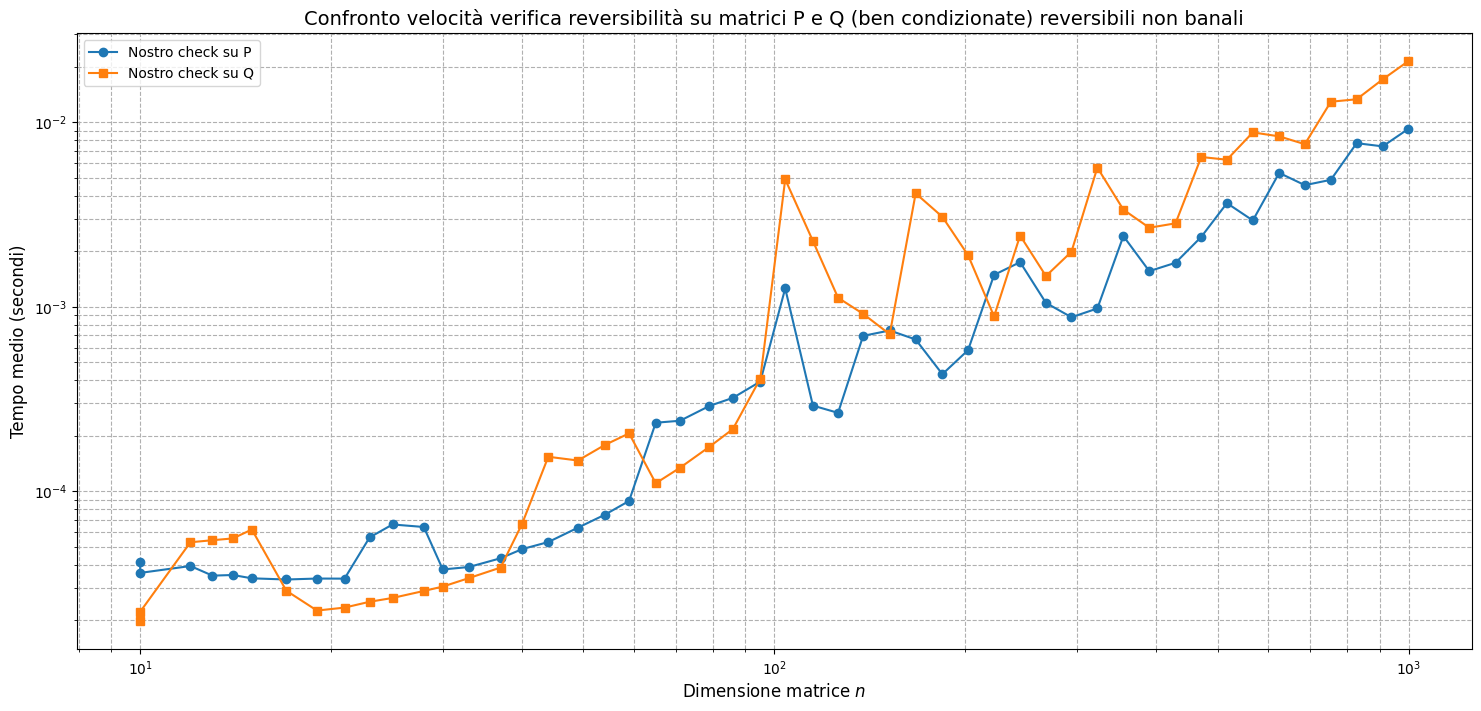

In [23]:
# Grafico
plt.figure(figsize=(18,8))
plt.plot([r[0] for r in ris_nostro], [r[1] for r in ris_nostro], 'o-', label="Nostro check su P")
plt.plot([r[0] for r in ris_pydtmc], [r[1] for r in ris_pydtmc], 's-', label="Nostro check su Q")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dimensione matrice $n$', fontsize=12)
plt.ylabel('Tempo medio (secondi)', fontsize=12)
plt.title('Confronto velocità verifica reversibilità su matrici P e Q (ben condizionate) reversibili non banali', fontsize=14)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig("P_Qbene.svg", dpi=300, format="svg", bbox_inches = "tight")
plt.show()

### Confronto tra Q ben condizionate e Q generate senza accortezza

In [24]:
# Testa su Q reversibili
ris_nostro = calcola_tempi("nostro", C=70, n_punti=50, discrete=False)

# Testa su Q reversibili "facili"
ris_pydtmc = calcola_tempi("nostro", C=70, n_punti=50, discrete=False, forzata=True)

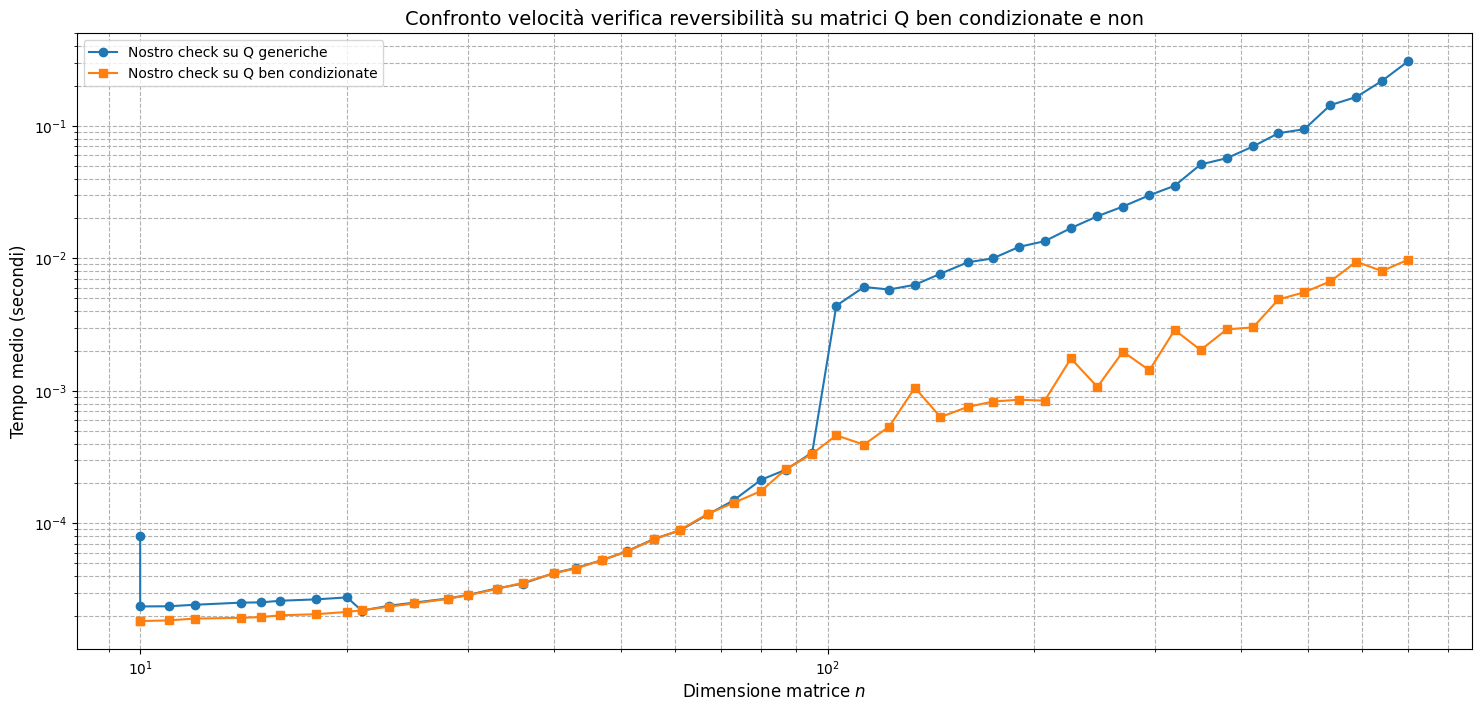

In [25]:
# Grafico
plt.figure(figsize=(18,8))
plt.plot([r[0] for r in ris_nostro], [r[1] for r in ris_nostro], 'o-', label="Nostro check su Q generiche")
plt.plot([r[0] for r in ris_pydtmc], [r[1] for r in ris_pydtmc], 's-', label="Nostro check su Q ben condizionate")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dimensione matrice $n$', fontsize=12)
plt.ylabel('Tempo medio (secondi)', fontsize=12)
plt.title('Confronto velocità verifica reversibilità su matrici Q ben condizionate e non', fontsize=14)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig("Qbene_Qnonbene.svg", dpi=300, format="svg", bbox_inches = "tight")
plt.show()